In [1]:
import csv
import numpy as np
from matplotlib import pyplot as plt

def load_dataset(filename):
    '''Loads an example of market basket transactions from a provided csv file.

    Returns: A list (database) of lists (transactions). Each element of a transaction is 
    an item.
    '''

    with open(filename,'r') as dest_f:
        data_iter = csv.reader(dest_f, delimiter = ',', quotechar = '"')
        data = [data for data in data_iter]
        data_array = np.asarray(data,dtype=object)
        
    return data_array

def apriori(dataset, min_support=0.5, verbose=False):
    """Implements the Apriori algorithm.

    The Apriori algorithm will iteratively generate new candidate 
    k-itemsets using the frequent (k-1)-itemsets found in the previous 
    iteration.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    Returns
    -------
    F : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.

    References
    ----------
    .. [1] R. Agrawal, R. Srikant, "Fast Algorithms for Mining Association 
           Rules", 1994.

    """
    C1 = create_candidates(dataset)
    D = list(map(set, dataset))
    F1, support_data = support_prune(D, C1, min_support, verbose=False) # prune candidate 1-itemsets
    F = [F1] # list of frequent itemsets; initialized to frequent 1-itemsets
    k = 2 # the itemset cardinality
    while (len(F[k - 2]) > 0):
        Ck = apriori_gen(F[k-2], k) # generate candidate itemsets
        Fk, supK = support_prune(D, Ck, min_support) # prune candidate itemsets
        support_data.update(supK) # update the support counts to reflect pruning
        F.append(Fk) # add the pruned candidate itemsets to the list of frequent itemsets
        k += 1

    if verbose:
        # Print a list of all the frequent itemsets.
        for kset in F:
            for item in kset:
                print("" \
                    + "{" \
                    + "".join(str(i) + ", " for i in iter(item)).rstrip(', ') \
                    + "}" \
                    + ":  sup = " + str(round(support_data[item], 3)))

    return F, support_data

def create_candidates(dataset, verbose=False):
    """Creates a list of candidate 1-itemsets from a list of transactions.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    Returns
    -------
    The list of candidate itemsets (c1) passed as a frozenset (a set that is 
    immutable and hashable).
    """
    c1 = [] # list of all items in the database of transactions
    for transaction in dataset:
        for item in transaction:
            if not [item] in c1:
                c1.append([item])
    c1.sort()

    if verbose:
        # Print a list of all the candidate items.
        print("" \
            + "{" \
            + "".join(str(i[0]) + ", " for i in iter(c1)).rstrip(', ') \
            + "}")

    # Map c1 to a frozenset because it will be the key of a dictionary.
    return list(map(frozenset, c1))

def support_prune(dataset, candidates, min_support, verbose=False):
    """Returns all candidate itemsets that meet a minimum support threshold.

    By the apriori principle, if an itemset is frequent, then all of its 
    subsets must also be frequent. As a result, we can perform support-based 
    pruning to systematically control the exponential growth of candidate 
    itemsets. Thus, itemsets that do not meet the minimum support level are 
    pruned from the input list of itemsets (dataset).

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    candidates : frozenset
        The list of candidate itemsets.

    min_support : float
        The minimum support threshold.

    Returns
    -------
    retlist : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.
    """
    sscnt = {} # set for support counts
    for tid in dataset:
        for can in candidates:
            if can.issubset(tid):
                sscnt.setdefault(can, 0)
                sscnt[can] += 1

    num_items = float(len(dataset)) # total number of transactions in the dataset
    retlist = [] # array for unpruned itemsets
    support_data = {} # set for support data for corresponding itemsets
    for key in sscnt:
        # Calculate the support of itemset key.
        support = sscnt[key] / num_items
        if support >= min_support:
            retlist.insert(0, key)
        support_data[key] = support

    # Print a list of the pruned itemsets.
    if verbose:
        for kset in retlist:
            for item in kset:
                print("{" + str(item) + "}")
        print("")
        for key in sscnt:
            print("" \
                + "{" \
                + "".join([str(i) + ", " for i in iter(key)]).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(support_data[key]))

    return retlist, support_data

def apriori_gen(freq_sets, k):
    """Generates candidate itemsets (via the F_k-1 x F_k-1 method).

    This operation generates new candidate k-itemsets based on the frequent 
    (k-1)-itemsets found in the previous iteration. The candidate generation 
    procedure merges a pair of frequent (k-1)-itemsets only if their first k-2 
    items are identical.

    Parameters
    ----------
    freq_sets : list
        The list of frequent (k-1)-itemsets.

    k : integer
        The cardinality of the current itemsets being evaluated.

    Returns
    -------
    retlist : list
        The list of merged frequent itemsets.
    """
    retList = [] # list of merged frequent itemsets
    lenLk = len(freq_sets) # number of frequent itemsets
    for i in range(lenLk):
        for j in range(i+1, lenLk):
            a=list(freq_sets[i])
            b=list(freq_sets[j])
            a.sort()
            b.sort()
            F1 = a[:k-2] # first k-2 items of freq_sets[i]
            F2 = b[:k-2] # first k-2 items of freq_sets[j]

            if F1 == F2: # if the first k-2 items are identical
                # Merge the frequent itemsets.
                retList.append(freq_sets[i] | freq_sets[j])

    return retList

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1, support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence 
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)
            
def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is 
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as 
    the support for P and H divided by the support for P 
    (support (P|H) / support(P)), where the | symbol denotes the set union 
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and 
    associated support data. For each frequent itemset, we divide the support 
    of the itemset by the support of the antecedent (left-hand-side of the 
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By 
    testing and merging the remaining rules, we recursively create a list of 
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([itemset]) for itemset in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)
    return rules

### To load our dataset of grocery transactions, use the command below

In [2]:
dataset = load_dataset('grocery.csv')
D = list(map(set, dataset))

### dataset is now a ndarray containing each of the 9835 transactions

In [3]:
type(dataset)

numpy.ndarray

In [4]:
dataset.shape

(9835,)

In [5]:
dataset[0]

['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']

In [6]:
dataset[1]

['tropical fruit', 'yogurt', 'coffee']

### D Contains that dataset in a set format (which excludes duplicated items and sorts them)

In [7]:
type(D[0])

set

In [8]:
D[0]

{'citrus fruit', 'margarine', 'ready soups', 'semi-finished bread'}

# Part 1 - Apriori

### Task 1: Your task here is to make use of the provided functions to generate candidate itemsets, select those that are frequent using Apriori, and subsequently list association rules derived from these.

In [9]:
# Generate candidate itemsets.
# candidate 1-itemsets
C1 = create_candidates(dataset, verbose=True) 

{Instant food products, UHT-milk, abrasive cleaner, artif. sweetener, baby cosmetics, baby food, bags, baking powder, bathroom cleaner, beef, berries, beverages, bottled beer, bottled water, brandy, brown bread, butter, butter milk, cake bar, candles, candy, canned beer, canned fish, canned fruit, canned vegetables, cat food, cereals, chewing gum, chicken, chocolate, chocolate marshmallow, citrus fruit, cleaner, cling film/bags, cocoa drinks, coffee, condensed milk, cooking chocolate, cookware, cream, cream cheese , curd, curd cheese, decalcifier, dental care, dessert, detergent, dish cleaner, dishes, dog food, domestic eggs, female sanitary products, finished products, fish, flour, flower (seeds), flower soil/fertilizer, frankfurter, frozen chicken, frozen dessert, frozen fish, frozen fruits, frozen meals, frozen potato products, frozen vegetables, fruit/vegetable juice, grapes, hair spray, ham, hamburger meat, hard cheese, herbs, honey, house keeping products, hygiene articles, ice c

In [10]:
# Generate all the frequent itemsets using the Apriori algorithm.
# We first try support threhold = 6%
F, support_data = apriori(dataset, min_support=0.06, verbose=True)

{domestic eggs}:  sup = 0.063
{whipped/sour cream}:  sup = 0.072
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{root vegetables}:  sup = 0.109
{pastry}:  sup = 0.089
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{soda}:  sup = 0.174
{bottled water}:  sup = 0.111
{bottled beer}:  sup = 0.081
{rolls/buns}:  sup = 0.184
{other vegetables}:  sup = 0.193
{pip fruit}:  sup = 0.076
{whole milk}:  sup = 0.256
{yogurt}:  sup = 0.14
{tropical fruit}:  sup = 0.105
{citrus fruit}:  sup = 0.083
{other vegetables, whole milk}:  sup = 0.075


In [11]:
# Generate the association rules from a list of frequent itemsets.
# We first try confidence threhold = 20%
H = generate_rules(F, support_data, min_confidence=0.2, verbose=True)

{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075


In [12]:
# Get the number of association rules.
print(len(H))

2


Comment: we can see that the list of candidate rules above the minimum confidence threshold gets shorter while we fix the support level and let the confidence level get higher. When we raise the support level up to 3%, there will be no candidate rules derived if the confidence level is 50%.  Thus, to get rules for analysis, it is subtle to what extent we plot the number of rules.  Too low will incur too much noise, while to high will rule out too much valuable data. 

### Task 2: We can find a relationship between the confidence level and number or rules found for a certain support value. For this, plot the number of rules found on y-axis and confidence levels on x-axis for different support values. Use 10%, 20%, 30%, 40%, 50% confidence levels for each of 2%, 3%, 4%, 5% support levels in the same figure.


In [13]:
confidence_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
support_levels = [0.02, 0.03, 0.04, 0.05]

In [14]:
# Function to build the relationship matrix by using Apriori
def relationship_support_confidence(dataset, confidence_levels, support_levels):
    relationships = []
    for support_level in support_levels:
        each_support = []
        F, support_data = apriori(dataset, min_support=support_level, verbose=True)
        for confidence_level in confidence_levels:
            H = generate_rules(F, support_data, min_confidence=confidence_level, verbose=True)
            each_support.append(len(H))
        relationships.append(each_support)
    return relationships

In [15]:
# Get the relationship between the confidence level and # of rules.
relationships = relationship_support_confidence(dataset,confidence_levels, support_levels)
print(relationships)

{meat}:  sup = 0.026
{sliced cheese}:  sup = 0.025
{onions}:  sup = 0.031
{frozen meals}:  sup = 0.028
{specialty chocolate}:  sup = 0.03
{frozen vegetables}:  sup = 0.048
{ice cream}:  sup = 0.025
{oil}:  sup = 0.028
{chewing gum}:  sup = 0.021
{ham}:  sup = 0.026
{cat food}:  sup = 0.023
{hard cheese}:  sup = 0.025
{misc. beverages}:  sup = 0.028
{domestic eggs}:  sup = 0.063
{dessert}:  sup = 0.037
{grapes}:  sup = 0.022
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{berries}:  sup = 0.033
{napkins}:  sup = 0.052
{hygiene articles}:  sup = 0.033
{hamburger meat}:  sup = 0.033
{beverages}:  sup = 0.026
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{waffles}:  sup = 0.038
{salty snack}:  sup = 0.038
{root vegetables}:  sup = 0.109
{candy}:  sup = 0.03
{pastry}:  sup = 0.089
{butter milk}:  sup = 0.028
{specialty bar}:  sup = 0.027
{sugar}:  sup = 0.034
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.

{onions}:  sup = 0.031
{specialty chocolate}:  sup = 0.03
{frozen vegetables}:  sup = 0.048
{domestic eggs}:  sup = 0.063
{dessert}:  sup = 0.037
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{berries}:  sup = 0.033
{napkins}:  sup = 0.052
{hygiene articles}:  sup = 0.033
{hamburger meat}:  sup = 0.033
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{waffles}:  sup = 0.038
{salty snack}:  sup = 0.038
{root vegetables}:  sup = 0.109
{pastry}:  sup = 0.089
{sugar}:  sup = 0.034
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{chicken}:  sup = 0.043
{soda}:  sup = 0.174
{frankfurter}:  sup = 0.059
{beef}:  sup = 0.052
{curd}:  sup = 0.053
{white bread}:  sup = 0.042
{chocolate}:  sup = 0.05
{bottled water}:  sup = 0.111
{bottled beer}:  sup = 0.081
{UHT-milk}:  sup = 0.033
{rolls/buns}:  sup = 0.184
{butter}:  sup = 0.055
{other vegetables}:  sup = 0.193
{long life bakery product}:  sup = 0.037
{pip fr

{domestic eggs}:  sup = 0.063
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{napkins}:  sup = 0.052
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{root vegetables}:  sup = 0.109
{pastry}:  sup = 0.089
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{soda}:  sup = 0.174
{frankfurter}:  sup = 0.059
{beef}:  sup = 0.052
{curd}:  sup = 0.053
{bottled water}:  sup = 0.111
{bottled beer}:  sup = 0.081
{rolls/buns}:  sup = 0.184
{butter}:  sup = 0.055
{other vegetables}:  sup = 0.193
{pip fruit}:  sup = 0.076
{whole milk}:  sup = 0.256
{yogurt}:  sup = 0.14
{tropical fruit}:  sup = 0.105
{coffee}:  sup = 0.058
{margarine}:  sup = 0.059
{citrus fruit}:  sup = 0.083
{rolls/buns, whole milk}:  sup = 0.057
{whole milk, yogurt}:  sup = 0.056
{other vegetables, whole milk}:  sup = 0.075
{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{yogurt

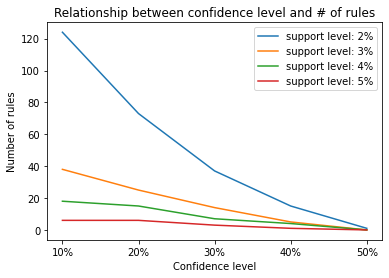

In [16]:
# plotting the points 
plt.plot(np.array(relationships).T, label=["support level: 2%",
                                "support level: 3%","support level: 4%","support level: 5%"])
  
# naming the x axis
plt.xlabel('Confidence level')
# naming the y axis
plt.ylabel('Number of rules')
x = ['10%', '20%', '30%', '40%', '50%']
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)

# giving a title to my graph
plt.title('Relationship between confidence level and # of rules')
plt.legend()
# function to show the plot
plt.show()

Note:
1. The higher the min support level, the less number of rules we get.
2. The higher the min confidence level, the less number of rules we get.
3. There is no rules when we raise the confidence level to 50%.


# Part 2 - FPgrowth:

In [17]:
from collections import defaultdict, namedtuple
#from itertools import imap

__author__ = 'Eric Naeseth <eric@naeseth.com>'
__copyright__ = 'Copyright © 2009 Eric Naeseth'
__license__ = 'MIT License'

def fpgrowth(dataset, min_support=0.5, include_support=True, verbose=False):
    """Implements the FP-growth algorithm.

    The `dataset` parameter can be any iterable of iterables of items.
    `min_support` should be an integer specifying the minimum number of
    occurrences of an itemset for it to be accepted.

    Each item must be hashable (i.e., it must be valid as a member of a
    dictionary or a set).

    If `include_support` is true, yield (itemset, support) pairs instead of
    just the itemsets.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    include_support : bool
        Include support in output (default=False).

    References
    ----------
    .. [1] J. Han, J. Pei, Y. Yin, "Mining Frequent Patterns without Candidate 
           Generation," 2000.

    """

    F = []
    support_data = {}
    for k,v in find_frequent_itemsets(dataset, min_support=min_support, include_support=include_support, verbose=verbose):
        F.append(frozenset(k))
        support_data[frozenset(k)] = v

    # Create one array with subarrays that hold all transactions of equal length.
    def bucket_list(nested_list, sort=True):
        bucket = defaultdict(list)
        for sublist in nested_list:
            bucket[len(sublist)].append(sublist)
        return [v for k,v in sorted(bucket.items())] if sort else bucket.values()

    F = bucket_list(F)
    
    if verbose:
        for kset in F:
                for item in kset:
                    print("" \
                        + "{" \
                        + "".join(str(i) + ", " for i in iter(item)).rstrip(', ') \
                        + "}" \
                        + ":  sup = " + str(round(support_data[item], 3)))
    
    return F, support_data

def find_frequent_itemsets(dataset, min_support, include_support=False, verbose=False):
    """
    Find frequent itemsets in the given transactions using FP-growth. This
    function returns a generator instead of an eagerly-populated list of items.

    The `dataset` parameter can be any iterable of iterables of items.
    `min_support` should be an integer specifying the minimum number of
    occurrences of an itemset for it to be accepted.

    Each item must be hashable (i.e., it must be valid as a member of a
    dictionary or a set).

    If `include_support` is true, yield (itemset, support) pairs instead of
    just the itemsets.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    include_support : bool
        Include support in output (default=False).

    """
    items = defaultdict(lambda: 0) # mapping from items to their supports
    processed_transactions = []

    # Load the passed-in transactions and count the support that individual
    # items have.
    for transaction in dataset:
        processed = []
        for item in transaction:
            items[item] += 1
            processed.append(item)
        processed_transactions.append(processed)

    # Remove infrequent items from the item support dictionary.
    items = dict((item, support) for item, support in items.items()
        if support >= min_support)

    # Build our FP-tree. Before any transactions can be added to the tree, they
    # must be stripped of infrequent items and their surviving items must be
    # sorted in decreasing order of frequency.
    def clean_transaction(transaction):
        #transaction = filter(lambda v: v in items, transaction)
        transaction.sort(key=lambda v: items[v], reverse=True)
        return transaction

    master = FPTree()
    for transaction in map(clean_transaction, processed_transactions):
        master.add(transaction)

    support_data = {}
    def find_with_suffix(tree, suffix):
        for item, nodes in tree.items():
            support = float(sum(n.count for n in nodes)) / len(dataset)
            if support >= min_support and item not in suffix:
                # New winner!
                found_set = [item] + suffix
                support_data[frozenset(found_set)] = support
                yield (found_set, support) if include_support else found_set

                # Build a conditional tree and recursively search for frequent
                # itemsets within it.
                cond_tree = conditional_tree_from_paths(tree.prefix_paths(item),
                    min_support)
                for s in find_with_suffix(cond_tree, found_set):
                    yield s # pass along the good news to our caller

    if verbose:
        # Print a list of all the frequent itemsets.
        for itemset, support in find_with_suffix(master, []):
            print("" \
                + "{" \
                + "".join(str(i) + ", " for i in iter(itemset)).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(round(support_data[frozenset(itemset)], 3)))

    # Search for frequent itemsets, and yield the results we find.
    for itemset in find_with_suffix(master, []):
        yield itemset

class FPTree(object):
    """
    An FP tree.

    This object may only store transaction items that are hashable (i.e., all
    items must be valid as dictionary keys or set members).
    """

    Route = namedtuple('Route', 'head tail')

    def __init__(self):
        # The root node of the tree.
        self._root = FPNode(self, None, None)

        # A dictionary mapping items to the head and tail of a path of
        # "neighbors" that will hit every node containing that item.
        self._routes = {}

    @property
    def root(self):
        """The root node of the tree."""
        return self._root

    def add(self, transaction):
        """
        Adds a transaction to the tree.
        """

        point = self._root

        for item in transaction:
            next_point = point.search(item)
            if next_point:
                # There is already a node in this tree for the current
                # transaction item; reuse it.
                next_point.increment()
            else:
                # Create a new point and add it as a child of the point we're
                # currently looking at.
                next_point = FPNode(self, item)
                point.add(next_point)

                # Update the route of nodes that contain this item to include
                # our new node.
                self._update_route(next_point)

            point = next_point

    def _update_route(self, point):
        """Add the given node to the route through all nodes for its item."""
        assert self is point.tree

        try:
            route = self._routes[point.item]
            route[1].neighbor = point # route[1] is the tail
            self._routes[point.item] = self.Route(route[0], point)
        except KeyError:
            # First node for this item; start a new route.
            self._routes[point.item] = self.Route(point, point)

    def items(self):
        """
        Generate one 2-tuples for each item represented in the tree. The first
        element of the tuple is the item itself, and the second element is a
        generator that will yield the nodes in the tree that belong to the item.
        """
        for item in self._routes.keys():
            yield (item, self.nodes(item))

            
    def nodes(self, item):
        """
        Generates the sequence of nodes that contain the given item.
        """

        try:
            node = self._routes[item][0]
        except KeyError:
            return

        while node:
            yield node
            node = node.neighbor

    def prefix_paths(self, item):
        """Generates the prefix paths that end with the given item."""

        def collect_path(node):
            path = []
            while node and not node.root:
                path.append(node)
                node = node.parent
            path.reverse()
            return path

        return (collect_path(node) for node in self.nodes(item))

    def inspect(self):
        print("Tree:")
        self.root.inspect(1)

        print("")
        print("Routes:")
        for item, nodes in self.items():
            print("  %r" % item)
            for node in nodes:
                print("    %r" % node)

    def _removed(self, node):
        """Called when `node` is removed from the tree; performs cleanup."""

        head, tail = self._routes[node.item]
        if node is head:
            if node is tail or not node.neighbor:
                # It was the sole node.
                del self._routes[node.item]
            else:
                self._routes[node.item] = self.Route(node.neighbor, tail)
        else:
            for n in self.nodes(node.item):
                if n.neighbor is node:
                    n.neighbor = node.neighbor # skip over
                    if node is tail:
                        self._routes[node.item] = self.Route(head, n)
                    break

def conditional_tree_from_paths(paths, min_support):
    """Builds a conditional FP-tree from the given prefix paths."""
    tree = FPTree()
    condition_item = None
    items = set()

    # Import the nodes in the paths into the new tree. Only the counts of the
    # leaf notes matter; the remaining counts will be reconstructed from the
    # leaf counts.
    for path in paths:
        if condition_item is None:
            condition_item = path[-1].item

        point = tree.root
        for node in path:
            next_point = point.search(node.item)
            if not next_point:
                # Add a new node to the tree.
                items.add(node.item)
                count = node.count if node.item == condition_item else 0
                next_point = FPNode(tree, node.item, count)
                point.add(next_point)
                tree._update_route(next_point)
            point = next_point

    assert condition_item is not None

    # Calculate the counts of the non-leaf nodes.
    for path in tree.prefix_paths(condition_item):
        count = path[-1].count
        for node in reversed(path[:-1]):
            node._count += count

    # Eliminate the nodes for any items that are no longer frequent.
    for item in items:
        support = sum(n.count for n in tree.nodes(item))
        if support < min_support:
            # Doesn't make the cut anymore
            for node in tree.nodes(item):
                if node.parent is not None:
                    node.parent.remove(node)

    # Finally, remove the nodes corresponding to the item for which this
    # conditional tree was generated.
    for node in tree.nodes(condition_item):
        if node.parent is not None: # the node might already be an orphan
            node.parent.remove(node)

    return tree

class FPNode(object):
    """A node in an FP tree."""

    def __init__(self, tree, item, count=1):
        self._tree = tree
        self._item = item
        self._count = count
        self._parent = None
        self._children = {}
        self._neighbor = None

    def add(self, child):
        """Adds the given FPNode `child` as a child of this node."""

        if not isinstance(child, FPNode):
            raise TypeError("Can only add other FPNodes as children")

        if not child.item in self._children:
            self._children[child.item] = child
            child.parent = self

    def search(self, item):
        """
        Checks to see if this node contains a child node for the given item.
        If so, that node is returned; otherwise, `None` is returned.
        """

        try:
            return self._children[item]
        except KeyError:
            return None

    def remove(self, child):
        try:
            if self._children[child.item] is child:
                del self._children[child.item]
                child.parent = None
                self._tree._removed(child)
                for sub_child in child.children:
                    try:
                        # Merger case: we already have a child for that item, so
                        # add the sub-child's count to our child's count.
                        self._children[sub_child.item]._count += sub_child.count
                        sub_child.parent = None # it's an orphan now
                    except KeyError:
                        # Turns out we don't actually have a child, so just add
                        # the sub-child as our own child.
                        self.add(sub_child)
                child._children = {}
            else:
                raise ValueError("that node is not a child of this node")
        except KeyError:
            raise ValueError("that node is not a child of this node")

    def __contains__(self, item):
        return item in self._children

    @property
    def tree(self):
        """The tree in which this node appears."""
        return self._tree

    @property
    def item(self):
        """The item contained in this node."""
        return self._item

    @property
    def count(self):
        """The count associated with this node's item."""
        return self._count

    def increment(self):
        """Increments the count associated with this node's item."""
        if self._count is None:
            raise ValueError("Root nodes have no associated count.")
        self._count += 1

    @property
    def root(self):
        """True if this node is the root of a tree; false if otherwise."""
        return self._item is None and self._count is None

    @property
    def leaf(self):
        """True if this node is a leaf in the tree; false if otherwise."""
        return len(self._children) == 0

    def parent():
        doc = "The node's parent."
        def fget(self):
            return self._parent
        def fset(self, value):
            if value is not None and not isinstance(value, FPNode):
                raise TypeError("A node must have an FPNode as a parent.")
            if value and value.tree is not self.tree:
                raise ValueError("Cannot have a parent from another tree.")
            self._parent = value
        return locals()
    parent = property(**parent())

    def neighbor():
        doc = """
        The node's neighbor; the one with the same value that is "to the right"
        of it in the tree.
        """
        def fget(self):
            return self._neighbor
        def fset(self, value):
            if value is not None and not isinstance(value, FPNode):
                raise TypeError("A node must have an FPNode as a neighbor.")
            if value and value.tree is not self.tree:
                raise ValueError("Cannot have a neighbor from another tree.")
            self._neighbor = value
        return locals()
    neighbor = property(**neighbor())

    @property
    def children(self):
        """The nodes that are children of this node."""
        return tuple(self._children.values())
        
    def inspect(self, depth=0):
        print(('  ' * depth) + repr(self))
        for child in self.children:
            child.inspect(depth + 1)

    def __repr__(self):
        if self.root:
            return "<%s (root)>" % type(self).__name__
        return "<%s %r (%r)>" % (type(self).__name__, self.item, self.count)

In [18]:
# Generate all the frequent itemsets using the FP-growth algorithm.
# We set 6% for min support level.
F2, support_data2 = fpgrowth(dataset, min_support=0.06, verbose=True)

{citrus fruit}:  sup = 0.083
{yogurt}:  sup = 0.14
{tropical fruit}:  sup = 0.105
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{other vegetables}:  sup = 0.193
{whole milk, other vegetables}:  sup = 0.075
{rolls/buns}:  sup = 0.184
{bottled beer}:  sup = 0.081
{bottled water}:  sup = 0.111
{soda}:  sup = 0.174
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{pastry}:  sup = 0.089
{root vegetables}:  sup = 0.109
{canned beer}:  sup = 0.078
{sausage}:  sup = 0.094
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{whipped/sour cream}:  sup = 0.072
{domestic eggs}:  sup = 0.063
{citrus fruit}:  sup = 0.083
{yogurt}:  sup = 0.14
{tropical fruit}:  sup = 0.105
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{other vegetables}:  sup = 0.193
{rolls/buns}:  sup = 0.184
{bottled beer}:  sup = 0.081
{bottled water}:  sup = 0.111
{soda}:  sup = 0.174
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{pastry}:  sup = 0.089
{root vegetables}:  sup 

In [19]:
# Generate the association rules from a list of frequent itemsets.
# We set 20% for min confidence level.
H2 = generate_rules(F2, support_data2, min_confidence=0.2, verbose=True)

{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075


The result is the same as Apriori for 6% support and 20% confidence level.

In [20]:
# Function to build the relationship matrix by using FPGrowth.
def relationship_support_confidence2(dataset, confidence_levels, support_levels):
    relationships = []
    for support_level in support_levels:
        each_support = []
        F, support_data = fpgrowth(dataset, min_support=support_level, verbose=True)
        for confidence_level in confidence_levels:
            H = generate_rules(F, support_data, min_confidence=confidence_level, verbose=True)
            each_support.append(len(H))
        relationships.append(each_support)
    return relationships

In [21]:
# Get the relationship between the confidence level and # of rules.
relationships2 = relationship_support_confidence2(dataset,confidence_levels, support_levels)

{citrus fruit}:  sup = 0.083
{whole milk, citrus fruit}:  sup = 0.031
{yogurt, citrus fruit}:  sup = 0.022
{other vegetables, citrus fruit}:  sup = 0.029
{margarine}:  sup = 0.059
{whole milk, margarine}:  sup = 0.024
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{soda, yogurt}:  sup = 0.027
{rolls/buns, yogurt}:  sup = 0.034
{other vegetables, yogurt}:  sup = 0.043
{whole milk, other vegetables, yogurt}:  sup = 0.022
{tropical fruit}:  sup = 0.105
{yogurt, tropical fruit}:  sup = 0.029
{other vegetables, tropical fruit}:  sup = 0.036
{whole milk, tropical fruit}:  sup = 0.042
{rolls/buns, tropical fruit}:  sup = 0.025
{root vegetables, tropical fruit}:  sup = 0.021
{soda, tropical fruit}:  sup = 0.021
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{whole milk, pip fruit}:  sup = 0.03
{tropical fruit, pip fruit}:  sup = 0.02
{other vegetables, pip fruit}:  sup = 0.026
{cream cheese}:  sup = 0.04
{other vegetables}:  sup = 0.193
{whole milk, other

{rolls/buns}:  sup = 0.184
{other vegetables, rolls/buns}:  sup = 0.043
{whole milk, rolls/buns}:  sup = 0.057
{bottled beer}:  sup = 0.081
{UHT-milk}:  sup = 0.033
{bottled water}:  sup = 0.111
{whole milk, bottled water}:  sup = 0.034
{chocolate}:  sup = 0.05
{white bread}:  sup = 0.042
{curd}:  sup = 0.053
{beef}:  sup = 0.052
{soda}:  sup = 0.174
{rolls/buns, soda}:  sup = 0.038
{whole milk, soda}:  sup = 0.04
{other vegetables, soda}:  sup = 0.033
{frankfurter}:  sup = 0.059
{chicken}:  sup = 0.043
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{sugar}:  sup = 0.034
{pastry}:  sup = 0.089
{whole milk, pastry}:  sup = 0.033
{root vegetables}:  sup = 0.109
{other vegetables, root vegetables}:  sup = 0.047
{whole milk, root vegetables}:  sup = 0.049
{waffles}:  sup = 0.038
{salty snack}:  sup = 0.038
{canned beer}:  sup = 0.078
{sausage}:  sup = 0.094
{rolls/buns, sausage}:  sup = 0.031
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{napkins}:  sup = 0.052

{curd}:  sup = 0.053
{beef}:  sup = 0.052
{soda}:  sup = 0.174
{whole milk, soda}:  sup = 0.04
{frankfurter}:  sup = 0.059
{chicken}:  sup = 0.043
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{pastry}:  sup = 0.089
{root vegetables}:  sup = 0.109
{other vegetables, root vegetables}:  sup = 0.047
{whole milk, root vegetables}:  sup = 0.049
{canned beer}:  sup = 0.078
{sausage}:  sup = 0.094
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{napkins}:  sup = 0.052
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{domestic eggs}:  sup = 0.063
{frozen vegetables}:  sup = 0.048
{citrus fruit}:  sup = 0.083
{margarine}:  sup = 0.059
{yogurt}:  sup = 0.14
{tropical fruit}:  sup = 0.105
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{other vegetables}:  sup = 0.193
{butter}:  sup = 0.055
{rolls/buns}:  sup = 0.184
{bottled beer}:  sup = 0.081
{bottled water}:  sup = 0.111
{chocolate}:  sup = 0.05
{white bread}:  sup = 0.042
{curd}:

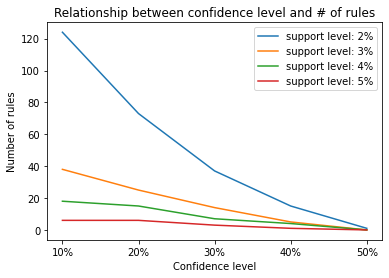

In [22]:
# plotting the points 
plt.plot(np.array(relationships2).T, label=["support level: 2%",
                                "support level: 3%","support level: 4%","support level: 5%"])
  
# naming the x axis
plt.xlabel('Confidence level')
# naming the y axis
plt.ylabel('Number of rules')
x = ['10%', '20%', '30%', '40%', '50%']
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x)

# giving a title to my graph
plt.title('Relationship between confidence level and # of rules')
plt.legend()
# function to show the plot
plt.show()

Note:

As we can see from the graph here, the result is exactly the same either using Apriori or FPGrowth method.

# Part 3 - Interest Factor

### Use either Apriori or FPgrowth algorithm with 4% support and 30% confidence to generate the rules. Now, calculate interest factor for all the rules. Recall, Interest Factor of (A ->B), I(A,B) is (Support(AUB)/(Support(A)*Support(B)))

In [23]:
# Generate all the frequent itemsets using the FP-growth algorithm.
F3, support_data3 = fpgrowth(dataset, min_support=0.04, verbose=True)

{citrus fruit}:  sup = 0.083
{margarine}:  sup = 0.059
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{other vegetables, yogurt}:  sup = 0.043
{tropical fruit}:  sup = 0.105
{whole milk, tropical fruit}:  sup = 0.042
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{other vegetables}:  sup = 0.193
{whole milk, other vegetables}:  sup = 0.075
{butter}:  sup = 0.055
{rolls/buns}:  sup = 0.184
{other vegetables, rolls/buns}:  sup = 0.043
{whole milk, rolls/buns}:  sup = 0.057
{bottled beer}:  sup = 0.081
{bottled water}:  sup = 0.111
{chocolate}:  sup = 0.05
{white bread}:  sup = 0.042
{curd}:  sup = 0.053
{beef}:  sup = 0.052
{soda}:  sup = 0.174
{whole milk, soda}:  sup = 0.04
{frankfurter}:  sup = 0.059
{chicken}:  sup = 0.043
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{pastry}:  sup = 0.089
{root vegetables}:  sup = 0.109
{other vegetables, root vegetables}:  sup = 0.047
{whole milk, root vegetables}:  sup = 0.049
{canned beer}

In [24]:
# Generate the association rules from a list of frequent itemsets.
H3 = generate_rules(F3, support_data3, min_confidence=0.3, verbose=True)

{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049


In [25]:
# Create list with confidence and support levels and interest factor for each rule
interest_factor = []
for rule in H3:
    A = rule[0]
    B = rule[1]
    a_b = A.union(B)
    sup_ab = support_data3[a_b]
    conf_ab = rule[2]
    sup_a = support_data3[A]
    sup_b = support_data3[B]
    i_ab = conf_ab / sup_b
    interest_factor.append((conf_ab, sup_ab, i_ab))
print(interest_factor)

[(0.40160349854227406, 0.05602440264361973, 1.5717351405345266), (0.3112244897959184, 0.04341637010676157, 1.6084565723294046), (0.40310077519379844, 0.04229791560752415, 1.5775949558420244), (0.38675775091960063, 0.07483477376715811, 1.5136340948246207), (0.30790491984521834, 0.05663446873411286, 1.2050317893663836), (0.43470149253731344, 0.047381799694966954, 2.2466049285887952), (0.44869402985074625, 0.048906964921199794, 1.7560309524799398)]


In [26]:
# sort the rules in descending order by interest factor
interest_factor.sort(key=lambda x:x[2],reverse=True)
interest_factor

[(0.43470149253731344, 0.047381799694966954, 2.2466049285887952),
 (0.44869402985074625, 0.048906964921199794, 1.7560309524799398),
 (0.3112244897959184, 0.04341637010676157, 1.6084565723294046),
 (0.40310077519379844, 0.04229791560752415, 1.5775949558420244),
 (0.40160349854227406, 0.05602440264361973, 1.5717351405345266),
 (0.38675775091960063, 0.07483477376715811, 1.5136340948246207),
 (0.30790491984521834, 0.05663446873411286, 1.2050317893663836)]

### Plot the rules as scatter plot with confidence levels on y-axis and support levels on x-axis.

In [27]:
# support level
x = []
# confidence level
y = []
# interet factor
c = []
for rule in interest_factor:
    x.append(rule[1])
    y.append(rule[0])
    c.append(rule[2])

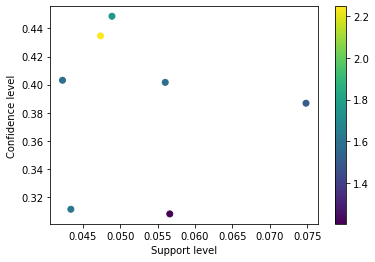

In [28]:
from matplotlib import pyplot as plt
from matplotlib import colors

plt.xlabel('Support level')
plt.ylabel('Confidence level')

cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(-2.5, 3, 1), cmap.N)

# plt.scatter(x, y, c)
sc = plt.scatter(x, y, c=c)
plt.colorbar(sc)

# plt.colorbar(ticks=np.linspace(-2, 2, 5))

plt.show()